In [1]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

def calculate_temperatures(S0, alpha, eps_s, eps_a, sigma=5.670374419e-8):
    """
    Calcule les températures de surface (T_s) et atmosphérique (T_a).

    Paramètres:
    - S0 : constante solaire (W/m²)
    - alpha : albédo de la planète
    - eps_s : émissivité de la surface
    - eps_a : émissivité de l'atmosphère
    - sigma : constante de Stefan-Boltzmann (par défaut 5.670374419e-8 W/m²·K⁴)

    Retourne:
    - T_s : température de surface (K)
    - T_a : température atmosphérique (K)
    """
    # Calcul de T_s
    numerator = (1 - alpha) * S0
    denominator = 4 * sigma * (1 - eps_a / 2)
    T_s = (numerator / denominator) ** 0.25

    # Calcul de T_a
    T_a = (eps_a * sigma * T_s ** 4 / (2 * sigma)) ** 0.25

    return T_s, T_a


In [2]:
# Paramètres
S0 = 1361       # W/m²
alpha = 0.3
eps_s = 1.0
eps_a = 0.77

# Calcul des températures
T_s, T_a = calculate_temperatures(S0, alpha, eps_s, eps_a)

print(f"Température de surface T_s = {T_s:.2f} K")
print(f"Température atmosphérique T_a = {T_a:.2f} K")


Température de surface T_s = 287.48 K
Température atmosphérique T_a = 226.45 K


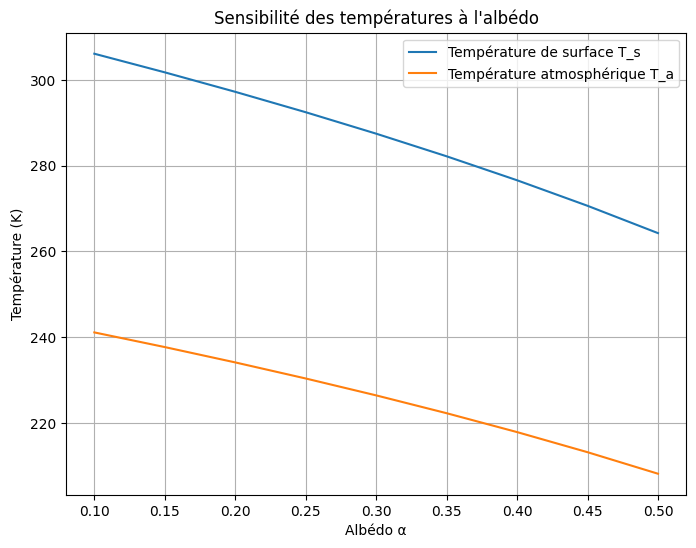

In [3]:
import matplotlib.pyplot as plt

alphas = np.linspace(0.1, 0.5, 9)
Ts_list = []
Ta_list = []

for alpha in alphas:
    T_s, T_a = calculate_temperatures(S0, alpha, eps_s, eps_a)
    Ts_list.append(T_s)
    Ta_list.append(T_a)

plt.figure(figsize=(8, 6))
plt.plot(alphas, Ts_list, label='Température de surface T_s')
plt.plot(alphas, Ta_list, label='Température atmosphérique T_a')
plt.xlabel('Albédo α')
plt.ylabel('Température (K)')
plt.title('Sensibilité des températures à l\'albédo')
plt.legend()
plt.grid(True)
plt.show()


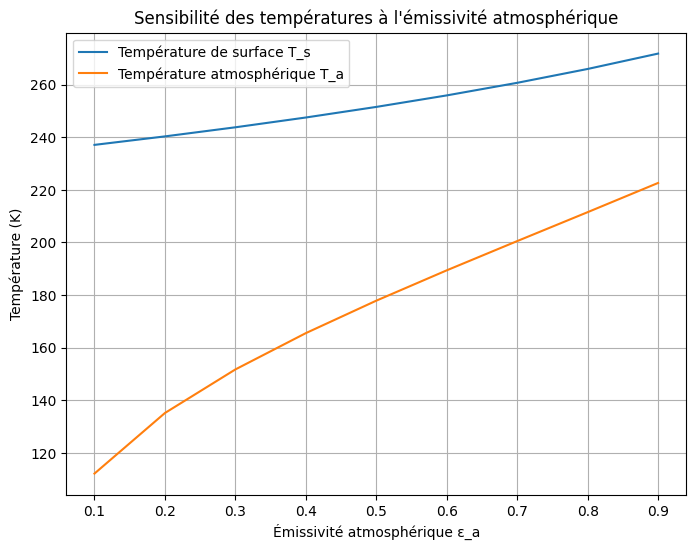

In [7]:
eps_as = np.linspace(0.1, 0.9, 9)
Ts_list = []
Ta_list = []

for eps_a in eps_as:
    T_s, T_a = calculate_temperatures(S0, alpha, eps_s, eps_a)
    Ts_list.append(T_s)
    Ta_list.append(T_a)

plt.figure(figsize=(8, 6))
plt.plot(eps_as, Ts_list, label='Température de surface T_s')
plt.plot(eps_as, Ta_list, label='Température atmosphérique T_a')
plt.xlabel('Émissivité atmosphérique ε_a')
plt.ylabel('Température (K)')
plt.title('Sensibilité des températures à l\'émissivité atmosphérique')
plt.legend()
plt.grid(True)
plt.show()


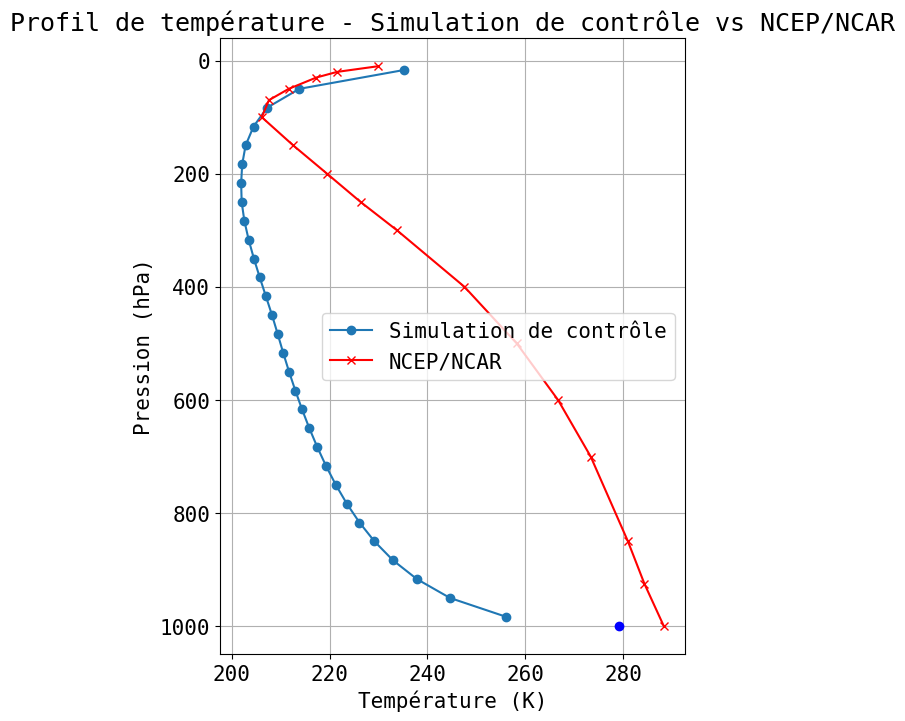

Figure sauvegardée:  ./figures/fig1.png


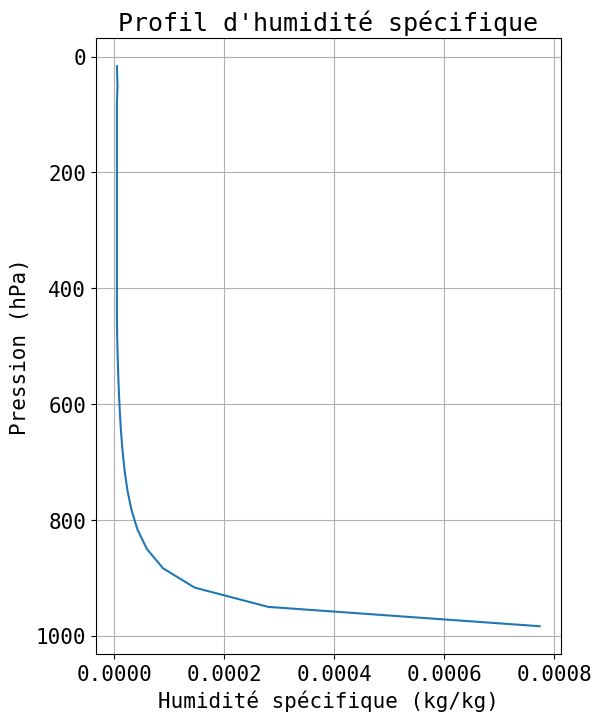

Figure sauvegardée:  ./figures/fig2.png
Flux radiatifs au sommet de l'atmosphère :
ASR (Absorbed Solar Radiation) = 243.26 W/m²
OLR (Outgoing Longwave Radiation) = 244.25 W/m²

Flux radiatifs à la surface :
Flux solaire net à la surface = 196.20 W/m²
Flux infrarouge net à la surface = 196.46 W/m²


In [11]:


import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as constants
import xarray as xr
import copy as cp

# Configuration des polices pour les graphiques
import matplotlib as matplotlib
font = {'family' : 'monospace',
        'size'   : 15}
matplotlib.rc('font', **font)



# Constantes et paramètres
units = r'W m$^{-2}$'
emiss_s = 1.0  # Émissivité de la surface
emiss_a = 0.77  # Émissivité de l'atmosphère
alb = 0.25  # Albédo de la surface
S0 = 1376.0  # Constante solaire (W/m²)
sigma = 5.6767E-08  # Constante de Stefan-Boltzmann
levels = np.arange(200, 330, 20)
Tlims = [180, 310]
Nz = 30  # Nombre de niveaux verticaux

# Chargement des profils NCEP (ajustez le chemin si nécessaire)
ncep_lev = np.load('C:/Users/thoma/Downloads/Experience3 (1)/npy/ncep_lev.npy')
ncep_T = np.load('C:/Users/thoma/Downloads/Experience3 (1)/npy/ncep_T.npy') + 273.15  # Conversion en K

# Variables d'état (Température de l'air et de la surface)
state = climlab.column_state(num_lev=Nz)

# Humidité relative fixe
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)

# Couplage de la vapeur d'eau au rayonnement
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)

# Création du modèle radiatif en équilibre
rcm = climlab.couple([rad, h2o], name='Radiative-Equilibrium Model')

# Initialisation de l'état isotherme
rcm.state.Tatm[:] = rcm.state.Ts

# Exécution du modèle jusqu'à l'équilibre
for t in range(1000):
    rcm.step_forward()
    if abs(rcm.ASR - rcm.OLR) < 1.0:  # Critère d'équilibre (W/m²)
        break

# Affichage du profil de température de la simulation de contrôle
plt.figure(figsize=(6,8))
plt.plot(rcm.Tatm[::-1], rcm.lev[::-1], label='Simulation de contrôle', marker='o')
plt.plot(rcm.Ts, 1000, marker='o', color='blue')
plt.plot(ncep_T, ncep_lev, label='NCEP/NCAR', marker='x', color='red')
plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.title('Profil de température - Simulation de contrôle vs NCEP/NCAR')
plt.legend()
plt.grid(True)
fig_name = outpath + 'fig1.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
print('Figure sauvegardée: ', fig_name)

# Affichage du profil d'humidité spécifique
plt.figure(figsize=(6,8))
plt.plot(rcm.q[::-1], rcm.lev[::-1], label='Humidité spécifique')
plt.gca().invert_yaxis()
plt.xlabel('Humidité spécifique (kg/kg)')
plt.ylabel('Pression (hPa)')
plt.title('Profil d\'humidité spécifique')
plt.grid(True)
fig_name = outpath + 'fig2.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
print('Figure sauvegardée: ', fig_name)

# Affichage des flux radiatifs au sommet de l'atmosphère et à la surface
print('Flux radiatifs au sommet de l\'atmosphère :')
ASR_value = rcm.ASR.to_xarray().values.item()
OLR_value = rcm.OLR.to_xarray().values.item()
print(f'ASR (Absorbed Solar Radiation) = {ASR_value:.2f} W/m²')
print(f'OLR (Outgoing Longwave Radiation) = {OLR_value:.2f} W/m²\n')

print('Flux radiatifs à la surface :')

# Extraction des profils de flux net
SW_flux_net_profile = rcm.SW_flux_net.to_xarray().values
LW_flux_net_profile = rcm.LW_flux_net.to_xarray().values

# Vérification de la longueur des profils
#print('Longueur du profil SW_flux_net:', len(SW_flux_net_profile))
#print('Longueur du profil LW_flux_net:', len(LW_flux_net_profile))

# Obtention des valeurs à la surface (dernier indice)
SW_flux_net_sfc_value = float(SW_flux_net_profile[-1])
LW_flux_net_sfc_value = float(LW_flux_net_profile[-1])

print(f'Flux solaire net à la surface = {SW_flux_net_sfc_value:.2f} W/m²')
print(f'Flux infrarouge net à la surface = {LW_flux_net_sfc_value:.2f} W/m²')


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


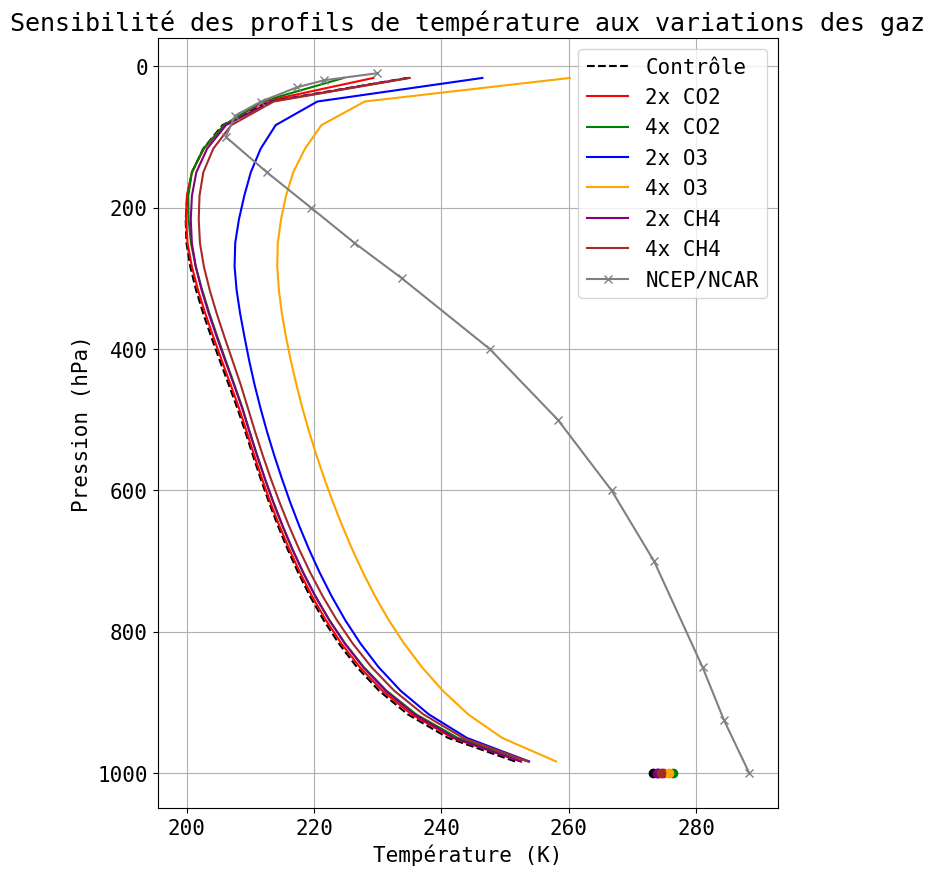

In [13]:


# Configuration des paramètres
alb = 0.3  # Albédo de la surface
Nz = 30  # Nombre de niveaux verticaux



# Simulation de contrôle
state = climlab.column_state(num_lev=Nz)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
rcm_control = climlab.couple([rad, h2o], name='Radiative-Convective Model')
rcm_control.integrate_years(2)

# Récupération des valeurs de contrôle
T_control = rcm_control.Tatm
Ts_control = rcm_control.Ts

# Liste des gaz à modifier
gases = ['CO2', 'O3', 'CH4']

# Facteurs de multiplication des concentrations
factors = [2, 4]  # Doublement et quadruplement

# Couleurs pour les tracés
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

plt.figure(figsize=(8, 10))

# Tracé de la simulation de contrôle
plt.plot(T_control[::-1], rcm_control.lev[::-1], label='Contrôle', color='black', linestyle='--')
plt.plot(Ts_control, 1000, marker='o', color='black')

# Boucle sur les gaz et les facteurs
for i, gas in enumerate(gases):
    for j, factor in enumerate(factors):
        # Création d'un nouvel état pour chaque simulation
        state = climlab.column_state(num_lev=Nz)
        h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
        rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
        rcm = climlab.couple([rad, h2o], name=f'Modèle avec {factor}x {gas}')
        
        # Modification de la concentration du gaz
        original_concentration = rad.absorber_vmr[gas]
        rad.absorber_vmr[gas] = original_concentration * factor
        
        # Intégration du modèle
        rcm.integrate_years(2)
        
        # Tracé du profil de température
        label = f'{factor}x {gas}'
        color = colors[i * len(factors) + j]
        plt.plot(rcm.Tatm[::-1], rcm.lev[::-1], label=label, color=color)
        plt.plot(rcm.Ts, 1000, marker='o', color=color)

# Tracé du profil NCEP/NCAR pour référence
plt.plot(ncep_T, ncep_lev, label='NCEP/NCAR', marker='x', color='gray')

plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.title('Sensibilité des profils de température aux variations des gaz')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


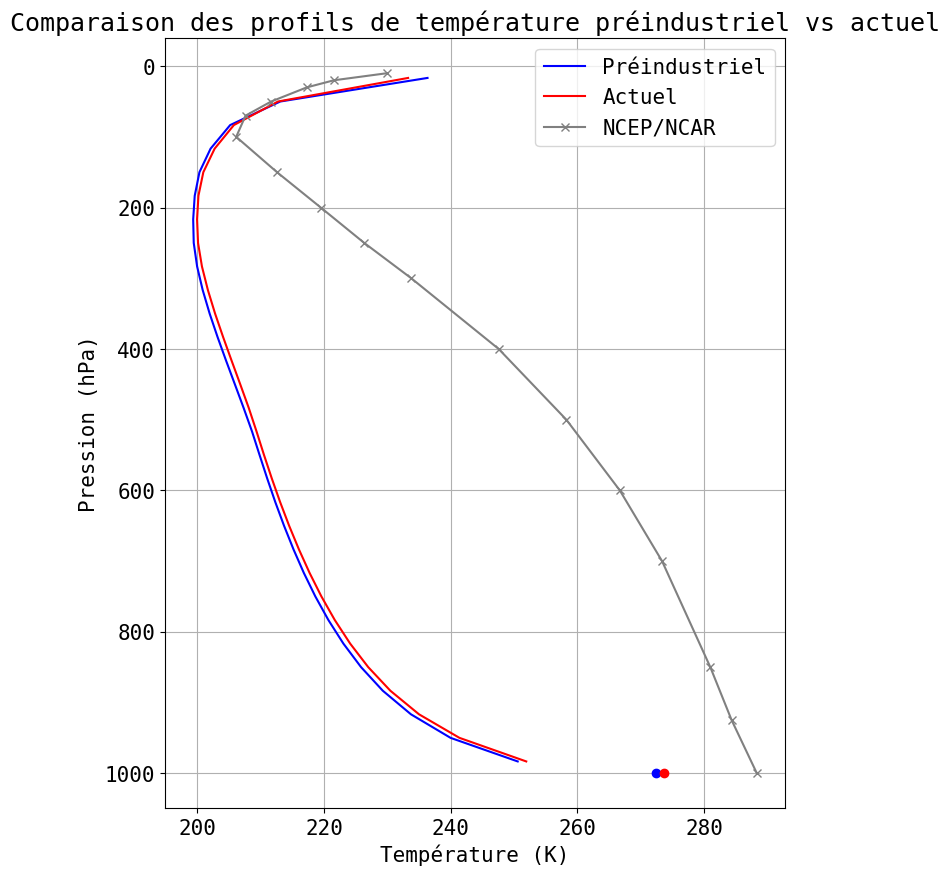

In [14]:
# Concentrations préindustrielles
preindustrial_concentrations = {
    'CO2': 280e-6,  # ppmv en fraction molaire
    'CH4': 700e-9,  # ppbv en fraction molaire
    # O3 reste inchangé pour simplifier
}

# Concentrations actuelles
current_concentrations = {
    'CO2': 415e-6,
    'CH4': 1870e-9,
}

# Simulation préindustrielle
state = climlab.column_state(num_lev=Nz)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
rcm_preindustrial = climlab.couple([rad, h2o], name='Préindustriel')

# Mise à jour des concentrations
rad.absorber_vmr['CO2'] = preindustrial_concentrations['CO2']
rad.absorber_vmr['CH4'] = preindustrial_concentrations['CH4']

rcm_preindustrial.integrate_years(2)

# Simulation actuelle
state = climlab.column_state(num_lev=Nz)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
rcm_current = climlab.couple([rad, h2o], name='Actuel')

# Mise à jour des concentrations
rad.absorber_vmr['CO2'] = current_concentrations['CO2']
rad.absorber_vmr['CH4'] = current_concentrations['CH4']

rcm_current.integrate_years(2)

# Tracé des profils
plt.figure(figsize=(8, 10))
plt.plot(rcm_preindustrial.Tatm[::-1], rcm_preindustrial.lev[::-1], label='Préindustriel', color='blue')
plt.plot(rcm_preindustrial.Ts, 1000, marker='o', color='blue')
plt.plot(rcm_current.Tatm[::-1], rcm_current.lev[::-1], label='Actuel', color='red')
plt.plot(rcm_current.Ts, 1000, marker='o', color='red')
plt.plot(ncep_T, ncep_lev, label='NCEP/NCAR', marker='x', color='gray')

plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.title('Comparaison des profils de température préindustriel vs actuel')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


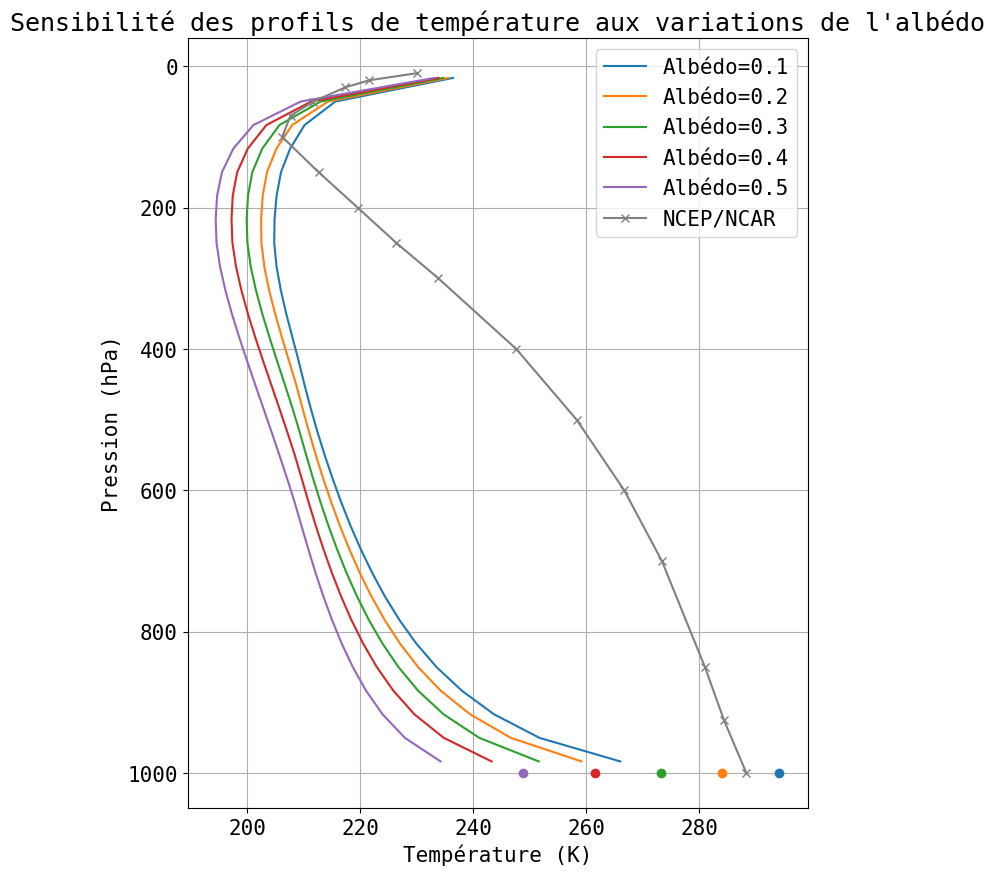

In [17]:

alb_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Différentes valeurs d'albédo
Nz = 30  # Nombre de niveaux verticaux


# Liste pour stocker les températures de surface
Ts_list = []

plt.figure(figsize=(8, 10))

# Obtenir une liste de couleurs depuis le cycle de couleurs de Matplotlib
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Boucle sur les valeurs d'albédo
for idx, alb in enumerate(alb_values):
    # Création du modèle
    state = climlab.column_state(num_lev=Nz)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(
        name='Radiation',
        state=state,
        specific_humidity=h2o.q,
        albedo=alb
    )
    rcm = climlab.couple([rad, h2o], name=f'Modèle avec albédo={alb}')
    rcm.integrate_years(2)
    
    # Stockage de la température de surface
    Ts_list.append(rcm.Ts)
    
    # Sélection de la couleur
    color = colors[idx % len(colors)]
    
    # Tracé du profil de température avec la couleur spécifiée
    plt.plot(rcm.Tatm[::-1], rcm.lev[::-1], label=f'Albédo={alb}', color=color)
    # Tracé du point de surface avec la même couleur
    plt.plot(rcm.Ts, 1000, marker='o', color=color)

# Tracé du profil NCEP/NCAR pour référence
plt.plot(ncep_T, ncep_lev, label='NCEP/NCAR', marker='x', color='gray')

plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.title('Sensibilité des profils de température aux variations de l\'albédo')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [18]:
# Concentration actuelle de CO₂
current_CO2 = 415e-6  # 415 ppmv

# Modèle avec concentration actuelle de CO₂
state = climlab.column_state(num_lev=Nz)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(
    name='Radiation',
    state=state,
    specific_humidity=h2o.q,
    albedo=0.3  # Albédo de référence
)
rcm_control = climlab.couple([rad, h2o], name='Contrôle')
rad.absorber_vmr['CO2'] = current_CO2
rcm_control.integrate_years(2)
Ts_control = rcm_control.Ts


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


In [19]:
# Doublement de la concentration de CO₂
doubled_CO2 = current_CO2 * 2

# Modèle avec doublement du CO₂
state = climlab.column_state(num_lev=Nz)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(
    name='Radiation',
    state=state,
    specific_humidity=h2o.q,
    albedo=0.3  # Même albédo
)
rcm_CO2_doubled = climlab.couple([rad, h2o], name='Doublement CO₂')
rad.absorber_vmr['CO2'] = doubled_CO2
rcm_CO2_doubled.integrate_years(2)
Ts_CO2_doubled = rcm_CO2_doubled.Ts


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


In [23]:
delta_Ts = Ts_CO2_doubled - Ts_control
delta_Ts_value = delta_Ts.to_xarray().values.item()
print(f'Augmentation de la température de surface due au doublement du CO₂ : {delta_Ts_value:.2f} K')


Augmentation de la température de surface due au doublement du CO₂ : 1.54 K


In [24]:
def simulate_Ts_for_albedo(albedo, CO2_concentration):
    state = climlab.column_state(num_lev=Nz)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(
        name='Radiation',
        state=state,
        specific_humidity=h2o.q,
        albedo=albedo
    )
    rcm = climlab.couple([rad, h2o], name=f'Modèle avec albédo={albedo}')
    rad.absorber_vmr['CO2'] = CO2_concentration
    rcm.integrate_years(2)
    return rcm.Ts

# Recherche de l'albédo compensateur
from scipy.optimize import fsolve

def func_to_solve(albedo):
    Ts = simulate_Ts_for_albedo(albedo, doubled_CO2)
    return Ts - Ts_control  # On cherche Ts égal à Ts_control

# Estimation initiale de l'albédo
albedo_initial_guess = 0.3

# Résolution
albedo_compensator = fsolve(func_to_solve, albedo_initial_guess)[0]
print(f'Albédo nécessaire pour compenser l\'augmentation de température : {albedo_compensator:.3f}')


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986

In [30]:
def simulate_Ts_for_albedo(albedo, CO2_concentration):
    state = climlab.column_state(num_lev=Nz)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(
        name='Radiation',
        state=state,
        specific_humidity=h2o.q,
        albedo=albedo
    )
    rcm = climlab.couple([rad, h2o], name=f'Modèle avec albédo={albedo}')
    rad.absorber_vmr['CO2'] = CO2_concentration
    rcm.integrate_years(2)
    return rcm.Ts, rcm  # Retourner Ts et le modèle rcm


In [31]:
def func_to_solve(albedo):
    Ts, _ = simulate_Ts_for_albedo(albedo, doubled_CO2)
    return (Ts - Ts_control).to_xarray().values.item()


In [32]:
# Simulation avec albédo compensateur
Ts_compensated, rcm_compensated = simulate_Ts_for_albedo(albedo_compensator, doubled_CO2)

delta_Ts_compensated = Ts_compensated - Ts_control
delta_Ts_compensated_value = delta_Ts_compensated.to_xarray().values.item()
print(f'Changement de température après compensation : {delta_Ts_compensated_value:.4f} K')


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Changement de température après compensation : 0.0000 K


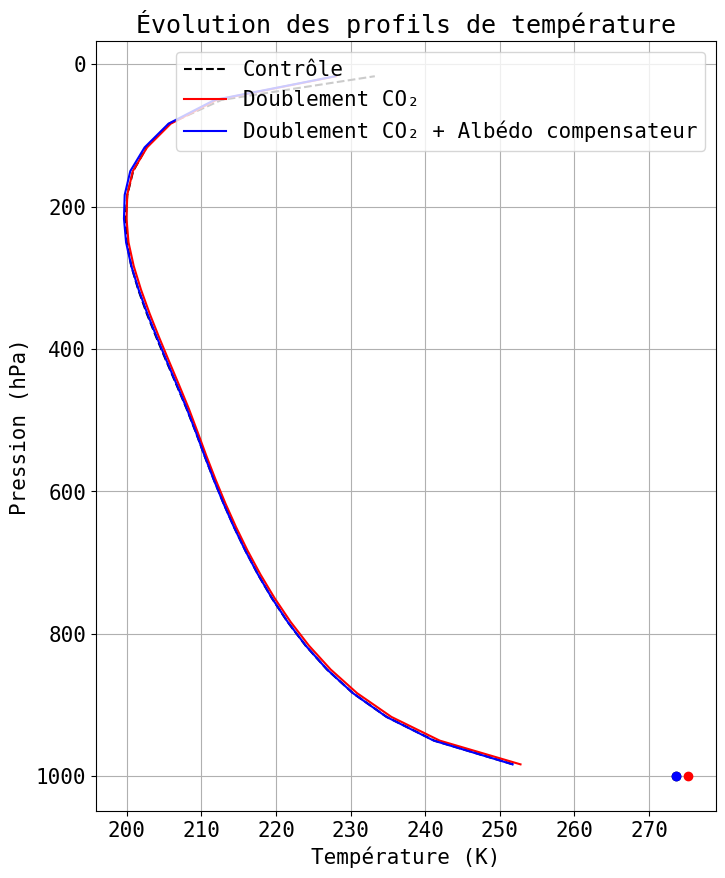

In [33]:
# Tracé des profils de température
plt.figure(figsize=(8, 10))
plt.plot(rcm_control.Tatm[::-1], rcm_control.lev[::-1], label='Contrôle', color='black', linestyle='--')
plt.plot(rcm_control.Ts, 1000, marker='o', color='black')
plt.plot(rcm_CO2_doubled.Tatm[::-1], rcm_CO2_doubled.lev[::-1], label='Doublement CO₂', color='red')
plt.plot(rcm_CO2_doubled.Ts, 1000, marker='o', color='red')
plt.plot(rcm_compensated.Tatm[::-1], rcm_compensated.lev[::-1], label='Doublement CO₂ + Albédo compensateur', color='blue')
plt.plot(rcm_compensated.Ts, 1000, marker='o', color='blue')

plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.title('Évolution des profils de température')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [40]:

# Nombre de niveaux verticaux
Nz = 30

# Albédo de la surface
alb = 0.3

# Fonction pour créer un modèle radiatif-convectif avec un adj_lapse_rate donné
def create_rcm_with_convection(adj_lapse_rate):
    # État initial
    state = climlab.column_state(num_lev=Nz)
    
    # Modèle radiatif-convectif
    rcm = climlab.RadiativeConvectiveModel(state=state, albedo=alb)
    
    # Modifier le adj_lapse_rate du processus de convection
    conv = rcm.subprocess['Convection']
    conv.adj_lapse_rate = adj_lapse_rate  # En K/m
    
    # Intégrer le modèle jusqu'à l'équilibre
    rcm.integrate_years(2)
    return rcm


In [54]:
# Nombre de niveaux verticaux
Nz = 30

# État initial de l'atmosphère
state = climlab.column_state(num_lev=Nz)




In [55]:
# Fraction de couverture nuageuse
cloud_fraction = 0.5

# Création des profils de nuages
def create_cloud_profile(cloud_type='low'):
    cloud = np.zeros(Nz)
    if cloud_type == 'low':
        # Nuages bas entre 800 hPa et 900 hPa
        cloud[(state.lev >= 800) & (state.lev <= 900)] = cloud_fraction
    elif cloud_type == 'high':
        # Nuages hauts entre 200 hPa et 300 hPa
        cloud[(state.lev >= 200) & (state.lev <= 300)] = cloud_fraction
    return cloud


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


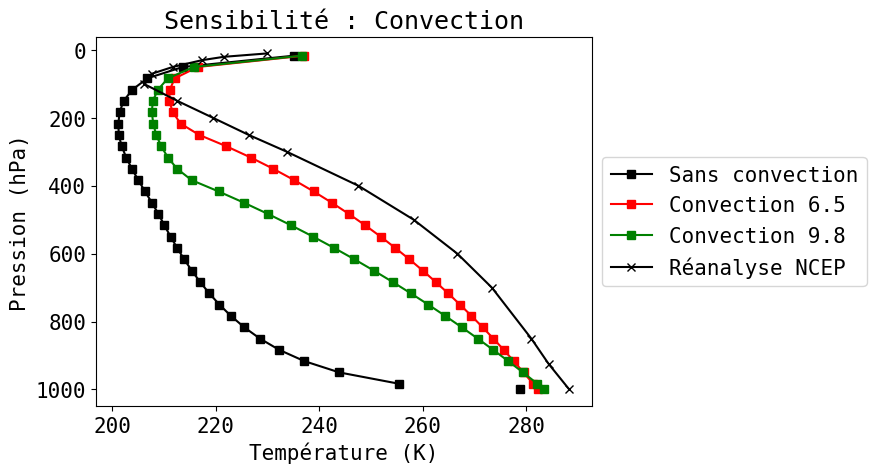

In [67]:

alb = 0.25  # Albédo surface
Nz = 30  # Nombre de niveaux verticaux
colors = ['k', 'r', 'g', 'orange']

# Chargement des profils NCEP (ajustez le chemin si nécessaire)
ncep_lev = np.load('C:/Users/thoma/Downloads/Experience3 (1)/npy/ncep_lev.npy')
ncep_T = np.load('C:/Users/thoma/Downloads/Experience3 (1)/npy/ncep_T.npy') + 273.15  # Conversion en K

# Modèle sans convection
state = climlab.column_state(num_lev=Nz)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
rcms = {'rcm0': climlab.couple([rad, h2o], name='Radiative-Convective Model')}

# Modèle avec convection ajustée à différents lapse rates
conv_6_5 = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=6.5)
rcms['rcm1'] = climlab.couple([rad, conv_6_5, h2o], name='Radiative-Convective Model')

conv_9_8 = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=9.8)
rcms['rcm2'] = climlab.couple([rad, conv_9_8, h2o], name='Radiative-Convective Model')

# Noms des simulations
mod_name = ['Sans convection', 'Convection 6.5', 'Convection 9.8']

# Exécuter les modèles et tracer les résultats
for ai, model_name in enumerate(mod_name):
    rcms[f'rcm{ai}'].integrate_years(2)
    plt.plot(rcms[f'rcm{ai}'].Tatm[::-1], rcms[f'rcm{ai}'].lev[::-1], marker='s', label=model_name, color=colors[ai])
    plt.plot(rcms[f'rcm{ai}'].Ts, 1000, marker='s', color=colors[ai])

# Ajouter les données de réanalyse NCEP pour comparaison
plt.plot(ncep_T, ncep_lev, marker='x', color='k', label='Réanalyse NCEP')
plt.gca().invert_yaxis()
plt.title('Sensibilité : Convection')
plt.ylabel('Pression (hPa)')
plt.xlabel('Température (K)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Afficher la figure
plt.show()



Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


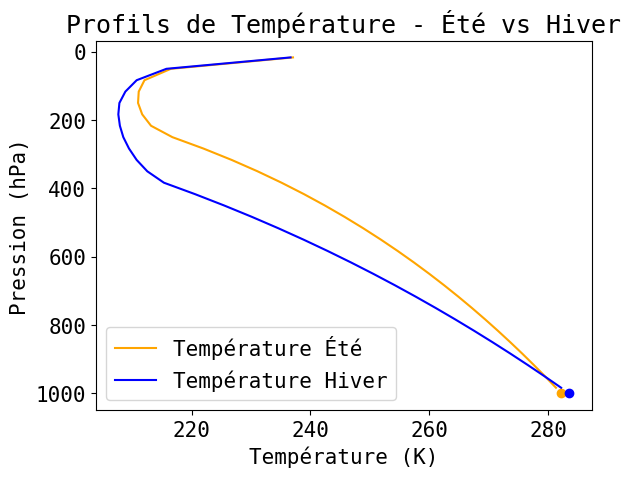

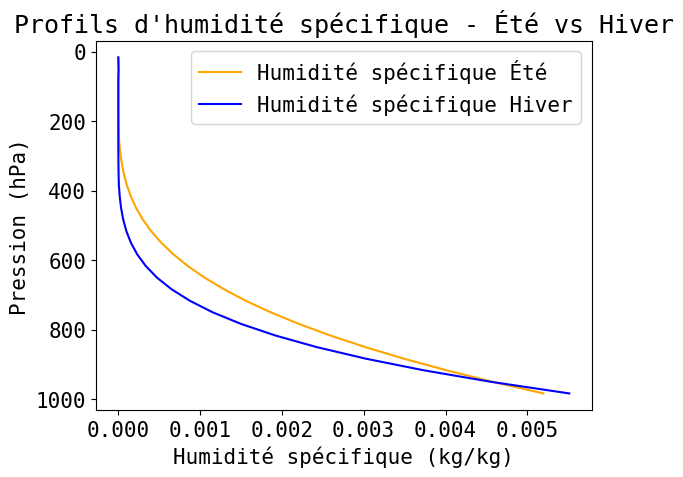

In [71]:

# Paramètres saisonniers
summer_S = 1376  # Intensité solaire estivale en W/m²
winter_S = 1000  # Intensité solaire hivernale en W/m²
lapse_rates = {'summer': 6.5, 'winter': 9.8}  # Lapse rates pour l'été et l'hiver
colors = {'summer': 'orange', 'winter': 'blue'}
labels = {'summer': 'Été', 'winter': 'Hiver'}

# Initialisation des modèles pour l'été et l'hiver
results = {}
for season in ['summer', 'winter']:
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=0.25)
    conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=lapse_rates[season])
    
    # Modèle couplé avec rayonnement et convection
    rcm = climlab.couple([rad, conv, h2o], name=f'Radiative-Convective Model ({season})')
    rcm.S0 = summer_S if season == 'summer' else winter_S
    rcm.integrate_years(1)  # Intégration sur une année pour chaque saison
    
    # Vérification et assignation de valeurs par défaut si les diagnostics sont absents
    ASR = rcm.diagnostics.get('ASR', 0)  # Flux solaire absorbé (W/m²)
    OLR = rcm.diagnostics.get('OLR', 0)  # Flux infrarouge sortant (W/m²)
    results[season] = {'model': rcm, 'ASR': ASR, 'OLR': OLR}

# Figure 1 : Profils de température
plt.figure()
for season in ['summer', 'winter']:
    plt.plot(results[season]['model'].Tatm[::-1], results[season]['model'].lev[::-1], label=f"Température {labels[season]}", color=colors[season])
    plt.plot(results[season]['model'].Ts, 1000, marker='o', color=colors[season])
plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.legend()
plt.title('Profils de Température - Été vs Hiver')
plt.show()

# Figure 2 : Profils d'humidité spécifique
plt.figure()
for season in ['summer', 'winter']:
    plt.plot(results[season]['model'].q[::-1], results[season]['model'].lev[::-1], label=f"Humidité spécifique {labels[season]}", color=colors[season])
plt.gca().invert_yaxis()
plt.xlabel('Humidité spécifique (kg/kg)')
plt.ylabel('Pression (hPa)')
plt.legend()
plt.title('Profils d\'humidité spécifique - Été vs Hiver')
plt.show()

